<a href="https://colab.research.google.com/github/tiboas/KmeansForQAM/blob/main/K_means_clustering_for_QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means clustering for QAM signals 

This notebook introduces the use of K-means clustering for QAM signals under different distortions. Issues with convergence is discussed and demonstrated. A simple example of how to apply knowledge about the system to aid the convergence of the algorithm and avoid converging to erroneous solutions. 



In [1]:
!pip install komm
#https://komm.readthedocs.io/en/latest/komm.AWGNChannel/

import komm as komm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

     |████████████████████████████████| 50 kB 2.2 MB/s 
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56608 sha256=b2b04df9bbccb8224c0ef10ea3a380d5cc4bcd9516441ae26457dd0d962ec8c0
  Stored in directory: /root/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built komm


Settings for the QAM signal 

In [2]:
#Settings
SNRdB = 20
Nsamples = 10000
M = 16 #number of constellation points, i.e. 16-QAM
# Note that currently the notebook onyl supports M up to 16 due to the manually defined color palette

#Set seed:
random.seed(42)
np.random.seed(42)

Defining a custom color palette and a plotting function that will be used when illustrating the convergence of the algorithm in scatter plots.

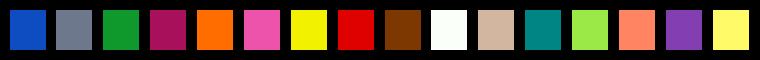

In [3]:
#Define a color palette for constellation plots:
def returnHex(C):
    return '#' + ''.join(f'{c:02x}' for c in C)

C =np.array([[14,77,193], [110,120,141],[15,153,45],  [168,16,91],
             [255, 108,0],[237,83,170], [242,242,0],  [223,0,0],
             [125,55,0],  [251,255,250],   [210,182,159],[0,133,133],
             [155,233,71],[255,133,98], [131,62,178], [255,250,103]]) / 255
wdt=75*10
colorImg = Image.new(mode="RGB", size=(wdt+10,60))
for i in range(16):
    temp = Image.new(mode="RGB", size=(int(wdt/16)-10,40), color=returnHex(np.int64(C[i]*255)))
    colorImg.paste(temp, (int(i*wdt/16)+10,10))
colorImg

In [4]:
# Function to plot constellations, with color coding for which cluster the points belong to, 
# and visualization of the found means.
def constPlotter(y,x_hat,c_means,C, legend='',title=''):
  plt.figure(figsize=(5,5))
  for k in range(len(C)):
    currentConst = y[x_hat==k]
    plt.plot(currentConst.real,currentConst.imag,'.',color=np.array(C[k]))
    plt.plot(c_means.real,c_means.imag,'o',color='k',markerfacecolor='w')
    plt.xticks([])
    plt.yticks([])

    plt.axis('equal')
    ax = plt.gca()
    ax.set_facecolor((0, 0., 0))
    if legend:
      plt.legend(legend,loc="upper left", bbox_to_anchor=(1,1))
    if title:
      plt.title(title)

    plt.draw()

Function to return a QAM signal

In [5]:
def returnQAM(M,Nsamples):
  tx = komm.QAModulation(16) #create 16QAM transmitter

  #Generate 16QAM-signal:
  b = np.random.randint(0,2,Nsamples*4) # *4 since 4 16QAM has 4 bits/symbol
  x = tx.modulate(b)
  x = x/np.sqrt(np.mean(np.abs(x)**2)) #normalize
  
  return x

# First example: K-means on a nonlinearly distorted signal with AWGN noise 

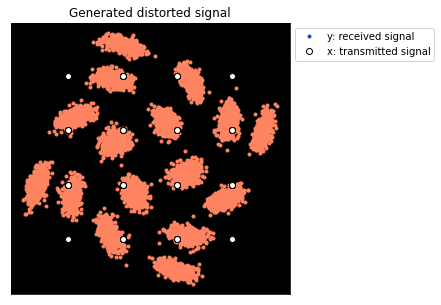

In [6]:
# Create 16-QAM signal:
x = returnQAM(M,Nsamples)

# Add AWGN noise:
awgn = komm.AWGNChannel(snr = 10**(SNRdB/10))
y = awgn(x)
# Create a nonlinear distortion:
y = y*np.exp(1j*abs(y)*0.75)

# Showcase the transmitted and distorted signal:
constPlotter(y,np.ones(y.shape)*13,np.unique(x),C,title='Generated distorted signal',legend=['y: received signal','x: transmitted signal'])

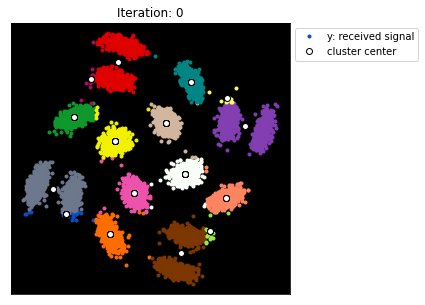

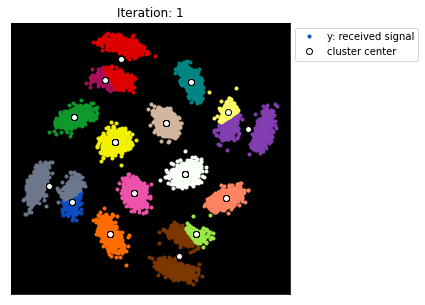

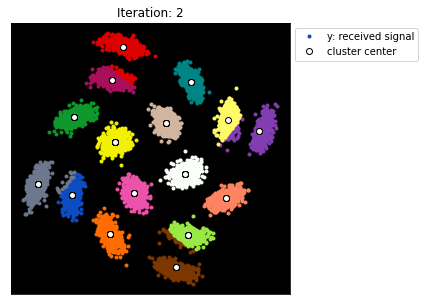

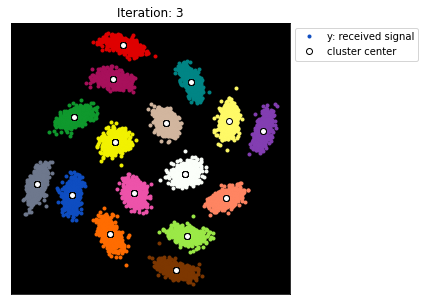

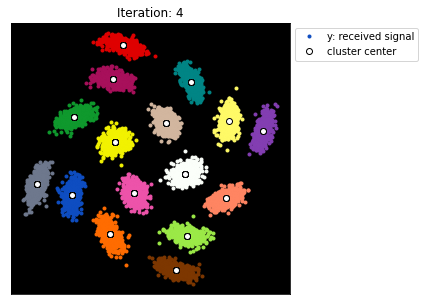

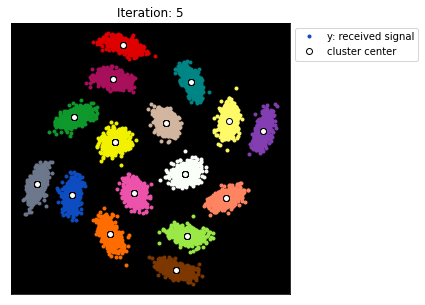

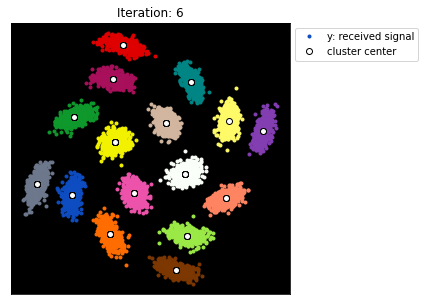

In [7]:
# Run k-means clustering: 
N_iterations = 7 #Numbers of iterations for calculating the means
c_means = np.unique(x) #Initialize the means to be the square 16QAM constellation
M = len(c_means)
dist = np.zeros((Nsamples,M))
# We will keep track of the cost to show convergence of the algorithm.
# Here the cost is defined the sum of the squared distance from the clustered points 
# and the corresponding centroid
cost_peritt = np.zeros(N_iterations) 
for n_itt in range(N_iterations):
  #Calculate the squared distance from each point to each of the M centroids:
  for k in range(M):
    dist[:,k] = np.square(np.abs(y-c_means[k]))
  
  #The points are clustered based on finding the minimum distance:
  x_hat = np.argmin(dist,1)

  #The new centroids are simply the mean of the cluster:
  cost = 0
  for k in range(M):
    c_means[k] = np.mean(y[x_hat == k])
    cost = cost + np.sum(np.square(np.abs(y[x_hat == k]-c_means[k]))) #Find the cost as described above
  cost_peritt[n_itt] = cost #Save the cost per iteration
  
  #Plot the clusters and found centroids for each iteration:
  constPlotter(y,x_hat,c_means,C, legend=['y: received signal','cluster center'], title='Iteration: ' + str(n_itt))


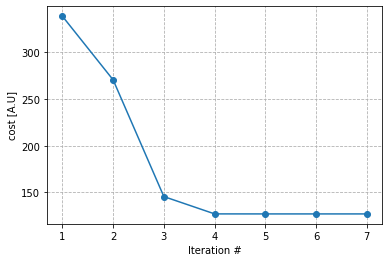

In [8]:
#Plot the cost per iteration:
plt.plot(np.array(range(len(cost_peritt)))+1,cost_peritt,'o-')
plt.xticks(np.array(range(len(cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Iteration #')
plt.draw()

**Conclusions for the example above:** For this exampe the algorithm has no issues converging. Only a few number of iterations are needed to reach a good state. 


---



# Second example: A distorted constellation where the k-means clustering is not converging to a good solution

Here we show an issue with k-means, which is that the result depends on the initialization of the centroids. In the previous example we set the centroids to be the original non-distorted 16-QAM constellation. In this case we initialize the centroids randomly. 

One way to work around this issue is to run the algorithm many times with random initialization each time and based on some chosen metric, choose the best case. However, for blind applications, i.e. with no knowledge on the signal, it can be hard to define a good metric for what is the best case.

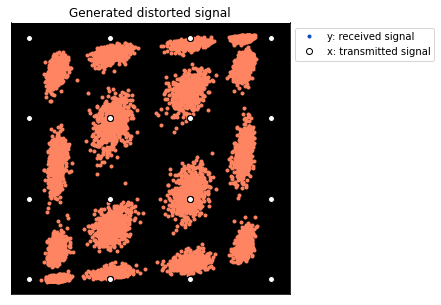

In [9]:
# Create 16 QAM signal:
x = returnQAM(M,Nsamples)

#Add AWGN noise:
SNRdB = 19
awgn = komm.AWGNChannel(snr = 10**(SNRdB/10))
y = awgn(x)

# Create a different type of nonlinear distortion:
y= np.tanh(y.real) + 1j*np.tanh((y*np.exp(1j*0.35)).imag*1.5)

# Showcase the transmitted and distorted signal:
constPlotter(y,np.ones(y.shape)*13,np.unique(x),C,title='Generated distorted signal',legend=['y: received signal','x: transmitted signal'])

**Note:** The scatter plots below are for the final iteration for each random initialization 

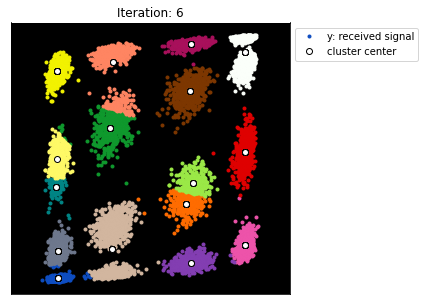

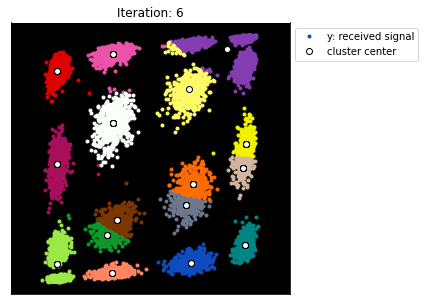

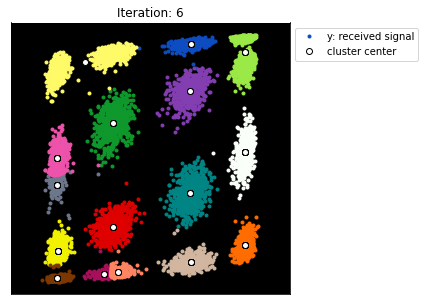

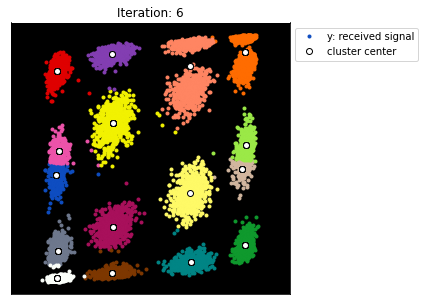

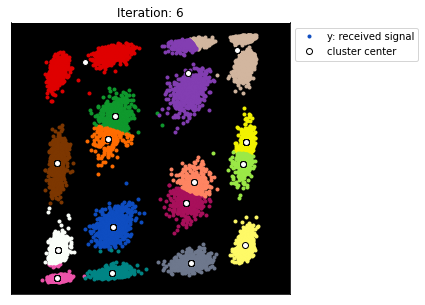

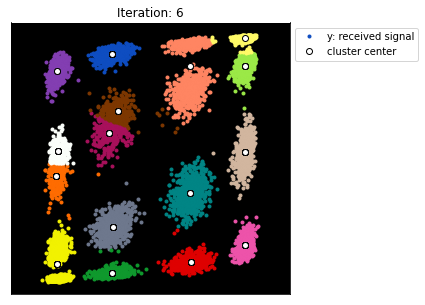

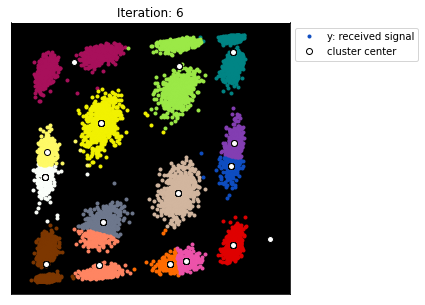

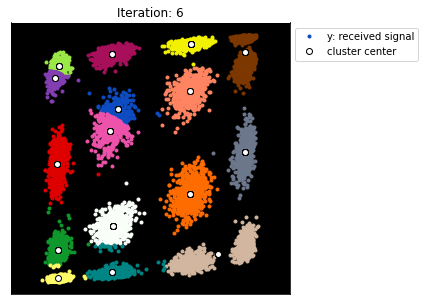

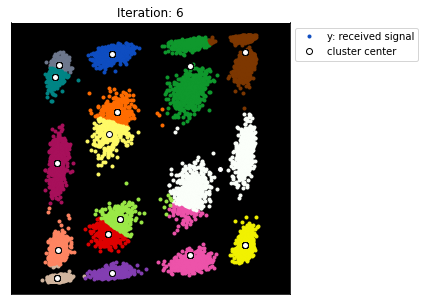

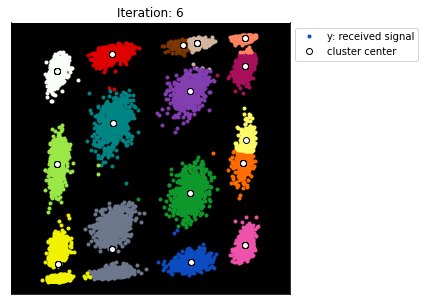

In [10]:
# Run k-means clustering: 
N_iterations = 7 #Numbers of iterations for calculating the means
N_random_starts = 10 #The number of random starts that will be used

cost_total= np.zeros((N_random_starts,N_iterations)) #To track the cost per iteration per random start 
for n_rand in range(N_random_starts):
  #In this case we chose 16 points by random since to get different initialization for each start:
  c_means = np.random.randn(M)+1j*np.random.randn(M) 

  dist = np.zeros((Nsamples,M))
  # We will keep track of the cost to show convergence of the algorithm.
  # Here the cost is defined the sum of the squared distance from the clustered points 
  # and the corresponding centroid
  cost_peritt = np.zeros(N_iterations) 
  for n_itt in range(N_iterations):
    #Calculate the squared distance from each point to each of the M centroids:
    for k in range(M):
      dist[:,k] = np.square(np.abs(y-c_means[k]))
    
    #The points are clustered based on finding the minimum distance:
    x_hat = np.argmin(dist,1)

    #The new centroids are simply the mean of the cluster:
    #In case one centroid ends up with no clustered points, we re-initialize it randomly 
    cost = 0
    for k in range(M):
      if not np.any(y[x_hat == k]):
        c_means[k] = np.random.randn(1)+1j*np.random.randn(1)
      else:
        c_means[k] = np.mean(y[x_hat == k])
      cost = cost + np.sum(np.square(np.abs(y[x_hat == k]-c_means[k]))) #Find the cost as described above

    cost_peritt[n_itt] = cost #Save the cost per iteration
    cost_total[n_rand,n_itt] = cost #Save the cost per iteration per random start
    
  #Plot the clusters and found centroids for last iteration for each random start:
  constPlotter(y,x_hat,c_means,C, legend=['y: received signal','cluster center'], title='Iteration: ' + str(n_itt))

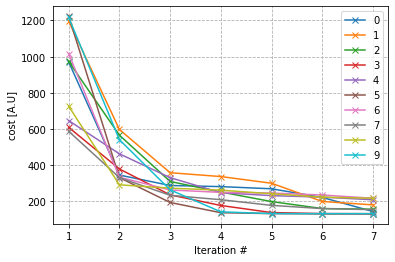

In [11]:
for k in range(N_random_starts):
  this_cost_peritt = cost_total[k,:]
  plt.plot(np.array(range(len(this_cost_peritt)))+1,this_cost_peritt,'x-')
plt.xticks(np.array(range(len(this_cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Iteration #')
plt.legend(range(N_random_starts))
plt.draw()

**Conclusions on the example above:** We can see a large spread in the outcome per random initialization, both looking at the defined cost function and looking at scatter plots with the found centroids. 

---

# Example 3: Using knowledge about the system to aid convergence 

We can see that none of the random starts above finds an acceptable clustering. Below we look at utilizing knowledge that we have about signal to help the algorithm converge. In this case we use the fact that we know that the probability per constellation point should be approximately 1/M. 

We will assume it to be exactly 1/M for the first few iterations, in reality it will vary a bit since we have a finite number of samples. We then limit the number of samples to be allowed per cluster to 1/M for these first few iterations. As can be seen below, this greatly helps the algorithm to converge and avoid getting stuck in convergence points where one "cloud" is split up into two different clusters. 

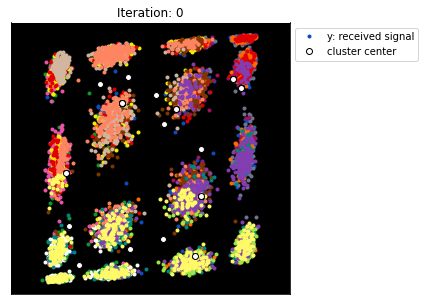

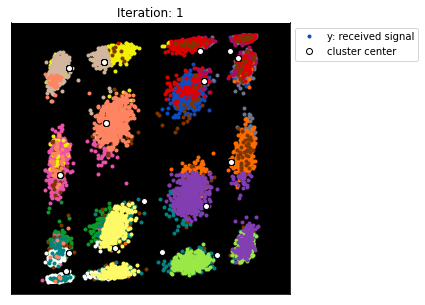

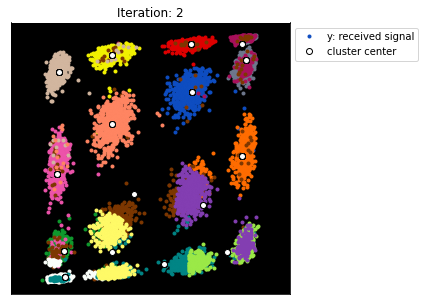

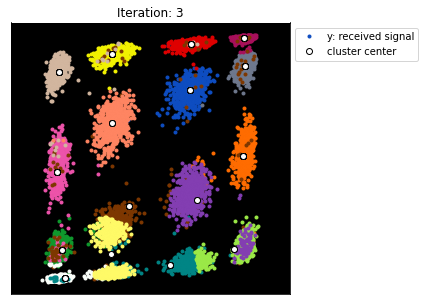

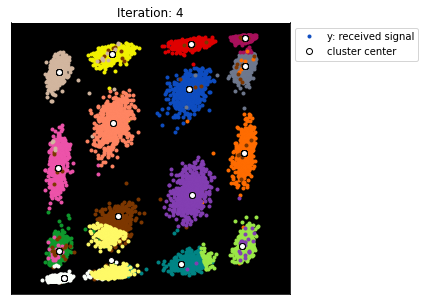

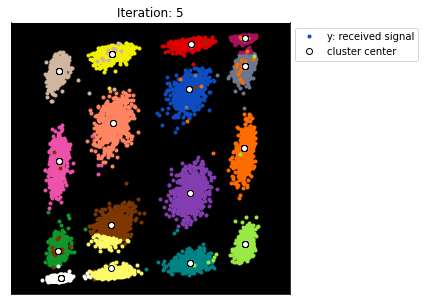

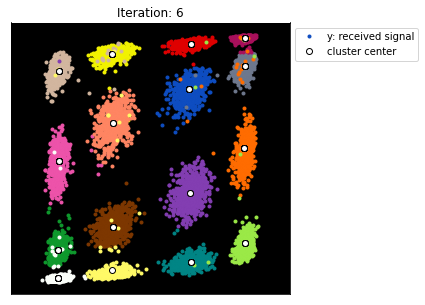

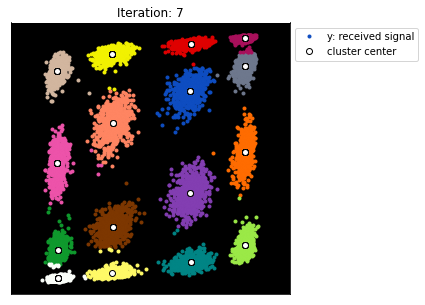

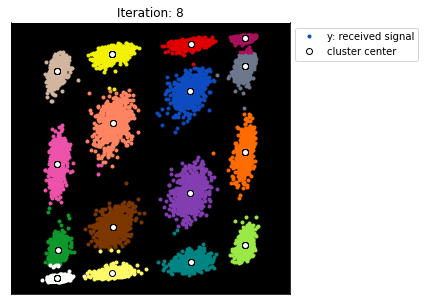

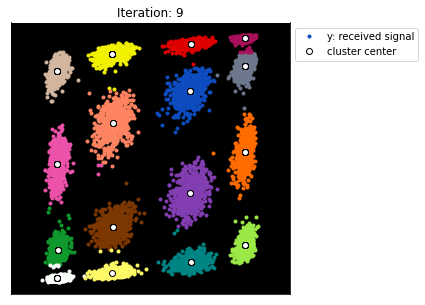

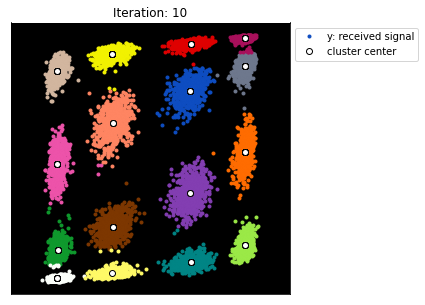

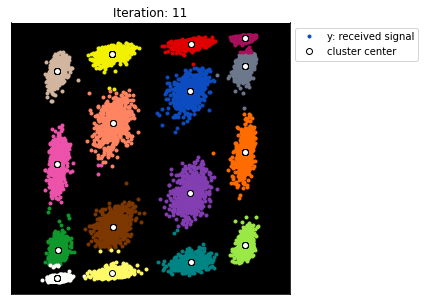

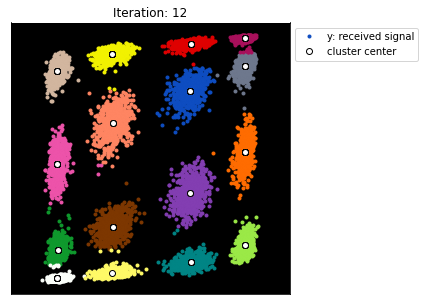

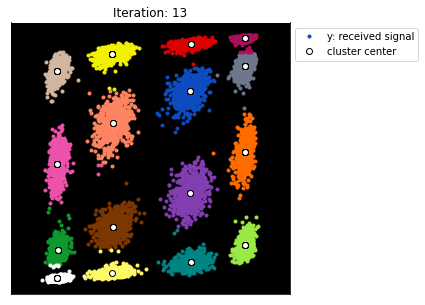

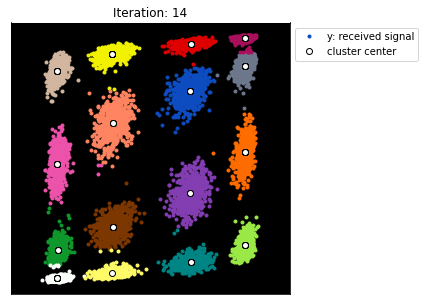

In [12]:
# Run k-means clustering: 
N_iterations = 15 #Numbers of iterations for calculating the means
N_random_starts = 1 #The number of random starts that will be used

cost_total= np.zeros((N_random_starts,N_iterations)) #To track the cost per iteration per random start 
for n_rand in range(N_random_starts):
  #In this case we chose 16 points by random since to get different initialization for each start:
  c_means = np.random.randn(M)+1j*np.random.randn(M) 

  dist = np.zeros((Nsamples,M))
  # We will keep track of the cost to show convergence of the algorithm.
  # Here the cost is defined the sum of the squared distance from the clustered points 
  # and the corresponding centroid
  cost_peritt = np.zeros(N_iterations) 
  for n_itt in range(N_iterations):
    #Calculate the squared distance from each point to each of the M centroids:
    for k in range(M):
      dist[:,k] = np.square(np.abs(y-c_means[k]))
    
    #The points are clustered based on finding the minimum distance:
    x_hat = np.argmin(dist,1)

    # We can utilize the fact that we know that each of the M symbols should have roughly the same probability. 
    # For the first few iterations we assume that P(M) = 1/M. 
    # However, we turn off this critera once after a few iterations to account for that in one batch of random data we dont have exactly 1/M sampels per constellation point. 
    if n_itt<7:
      Nmax = int(Nsamples/M)
      Ncount = np.zeros(16)
      for l in range(Nsamples):
        crit = 1
        while crit:
          dec = np.argmin(dist[l,:])
          if Ncount[dec] > Nmax:
            dist[l,dec] = 1e99 #really large number
          else:
            crit = 0    
        Ncount[dec]+=1       
        x_hat[l] = dec

    #The new centroids are simply the mean of the cluster:
    #In case one centroid ends up with no clustered points, we re-initialize it randomly 
    cost = 0
    for k in range(M):
      if not np.any(y[x_hat == k]):
        c_means[k] = np.random.randn(1)+1j*np.random.randn(1)
      else:
        c_means[k] = np.mean(y[x_hat == k])
      cost = cost + np.sum(np.square(np.abs(y[x_hat == k]-c_means[k]))) #Find the cost as described above

    cost_peritt[n_itt] = cost #Save the cost per iteration
    cost_total[n_rand,n_itt] = cost #Save the cost per iteration per random start
    
    #Plot the clusters and found centroids for last iteration for each random start:
    constPlotter(y,x_hat,c_means,C, legend=['y: received signal','cluster center'], title='Iteration: ' + str(n_itt))

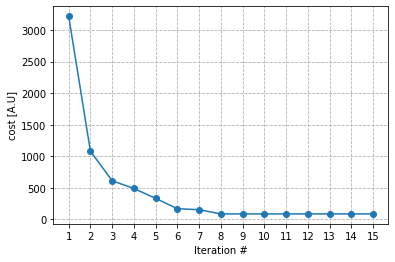

In [13]:
plt.plot(np.array(range(len(cost_peritt)))+1,cost_peritt,'o-')
plt.xticks(np.array(range(len(cost_peritt)))+1)
plt.grid('major',linestyle='--',)
plt.ylabel('cost [A.U]')
plt.xlabel('Iteration #')
plt.draw()

**Conclusions for the example above:** We can see both from the cost function and the scatter plot that with the added modification, we get a good convergence.